In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from Models.ResNet import ResNet18
from Models.VisionTransformer import VisionTransformerModel
from Models.ViTResNetMixed import ViTResNet
from Models.ResNet import MiniResNet
from utils.Training import Train
from utils.CustomDataset import CustomDataset

In [2]:
# Loading the data
TestData, TestLabels = [], []
TrainData, TrainLabels = [], []

LabelToId = {'no': 0, 'sphere':1, 'vort':2}

# Walking through the train directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask1/train"):
    for dir in dirs:
        for root2, dirs2, files2 in os.walk(os.path.join(root, dir)):
            for file in files2:
                TrainData.append(np.load(os.path.join(root2, file)))
                TrainLabels.append(LabelToId[dir])

# Walking through the test directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask1/val"):
    for dir in dirs:
        for root2, dirs2, files2 in os.walk(os.path.join(root, dir)):
            for file in files2:
                TestData.append(np.load(os.path.join(root2, file)))
                TestLabels.append(LabelToId[dir])

TestData = np.array(TestData)
TrainData = np.array(TrainData)

In [3]:
np.unique(TrainLabels, return_counts=True), np.unique(TestLabels, return_counts=True)

((array([0, 1, 2]), array([10000, 10000, 10000])),
 (array([0, 1, 2]), array([2500, 2500, 2500])))

In [4]:
TestLabels = torch.Tensor(TestLabels)
TestData = torch.Tensor(TestData)
TrainLabels = torch.Tensor(TrainLabels)
TrainData = torch.Tensor(TrainData)

TestDataset = CustomDataset(TestData, TestLabels)
TrainDataset = CustomDataset(TrainData, TrainLabels)

# Splitting and creating the dataset into training and validation
TrainLen = int(0.9 * len(TrainDataset))
ValLen = len(TrainDataset) - TrainLen

TrainDataset, ValidationDataset = random_split(TrainDataset, lengths=[TrainLen, ValLen])

In [5]:
len(TrainDataset), len(ValidationDataset), len(TestDataset)

(27000, 3000, 7500)

In [6]:
TrainLoader = DataLoader(TrainDataset, batch_size=32, shuffle=True)
ValidationLoader = DataLoader(ValidationDataset, batch_size=32, shuffle=True)
TestLoader = DataLoader(TestDataset, batch_size=32, shuffle=True)

In [11]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")   # I have a MacBook hence this option


# Building the model: 
model1 = ResNet18(input_size=150, in_channels= 1, num_classes= 3).to(device)

print(f"Using device: {device}")

Using device: mps


100%|██████████| 94/94 [00:01<00:00, 54.10it/s]



Epoch 1/90 -
	Training Loss: 1.099468336286138 
	Accuracy: 10.636255924170616
	AUC Score: 0.5020553661070699

	Val Loss: 1.0993627702936213 
	Val Accuracy: 10.72340425531915
	Val AUC Score: 0.4986106345122005



100%|██████████| 94/94 [00:01<00:00, 53.38it/s]



Epoch 11/90 -
	Training Loss: 1.0009422114392592 
	Accuracy: 14.932464454976303
	AUC Score: 0.6897755900984427

	Val Loss: 0.9869435201299951 
	Val Accuracy: 15.861702127659575
	Val AUC Score: 0.7036503004147172



100%|██████████| 94/94 [00:01<00:00, 53.64it/s]



Epoch 21/90 -
	Training Loss: 0.9266358329362779 
	Accuracy: 17.32345971563981
	AUC Score: 0.7580137806228522

	Val Loss: 0.9319638464045017 
	Val Accuracy: 17.25531914893617
	Val AUC Score: 0.7566262571077159



100%|██████████| 94/94 [00:01<00:00, 52.51it/s]



Epoch 31/90 -
	Training Loss: 0.8922303256124117 
	Accuracy: 18.49170616113744
	AUC Score: 0.7861957785139503

	Val Loss: 0.9125611623550983 
	Val Accuracy: 17.95744680851064
	Val AUC Score: 0.7724238054710981



100%|██████████| 94/94 [00:01<00:00, 52.53it/s]



Epoch 41/90 -
	Training Loss: 0.8352971618633135 
	Accuracy: 21.849526066350712
	AUC Score: 0.8562588262821583

	Val Loss: 0.8697123819209159 
	Val Accuracy: 20.77659574468085
	Val AUC Score: 0.8236029763886276



100%|██████████| 94/94 [00:01<00:00, 52.58it/s]



Epoch 51/90 -
	Training Loss: 0.7791792484115085 
	Accuracy: 24.05687203791469
	AUC Score: 0.8994902273826368

	Val Loss: 0.8161099407267063 
	Val Accuracy: 22.627659574468087
	Val AUC Score: 0.8727862342351537



100%|██████████| 94/94 [00:01<00:00, 53.03it/s]



Epoch 61/90 -
	Training Loss: 0.7399020526222708 
	Accuracy: 25.453791469194314
	AUC Score: 0.924003738948247

	Val Loss: 0.7870323619943984 
	Val Accuracy: 23.78723404255319
	Val AUC Score: 0.8957917265341242



100%|██████████| 94/94 [00:01<00:00, 52.72it/s]



Epoch 71/90 -
	Training Loss: 0.7079839778454948 
	Accuracy: 26.610189573459717
	AUC Score: 0.9451062184659559

	Val Loss: 0.760312351774662 
	Val Accuracy: 24.851063829787233
	Val AUC Score: 0.9139973659538092



100%|██████████| 94/94 [00:01<00:00, 52.20it/s]



Epoch 81/90 -
	Training Loss: 0.681694978009468 
	Accuracy: 27.518957345971565
	AUC Score: 0.9576520924738154

	Val Loss: 0.7563797241829812 
	Val Accuracy: 24.819148936170212
	Val AUC Score: 0.9174009945007443



100%|██████████| 94/94 [00:01<00:00, 53.87it/s]


Final Performance:
	Training Loss: 0.8320448595718563
	Test Loss: 0.8674847097261577
	Training Accuracy : 21.535584518167454
	Test Accuracy : 20.375768321513
	Training AUC Score : 86.43314662622173
	Test AUC Score : 0.8106042000990435
Finished Training


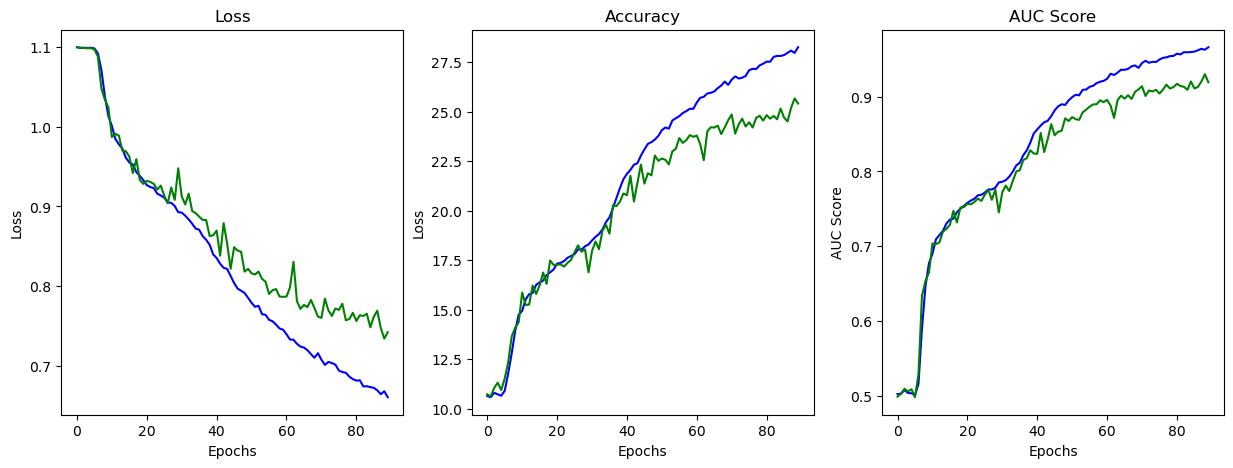

In [12]:
LossFunc = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

Train(model1, TrainLoader, ValidationLoader, LossFunc, Optimizer, 90, device)
# Experimented with different number of epoch scores to get this output.

In [13]:
torch.save(model1, "../ModelWeights/ResNet18.pth")

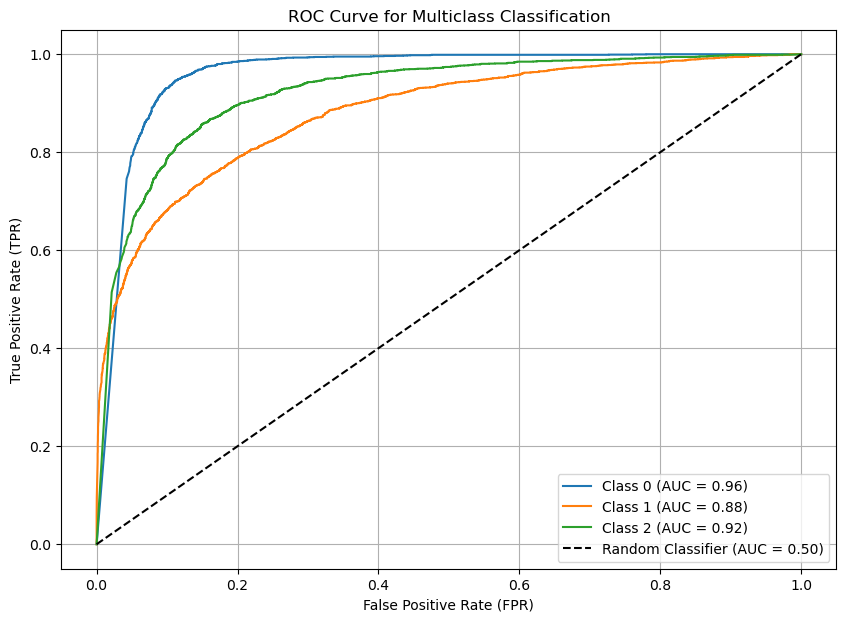

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_pred, num_classes):
    y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 7))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
    
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve for Multiclass Classification")
    plt.legend()
    plt.grid()
    plt.show()


def evaluate_model_roc(model, dataloader, device, num_classes):
    model.eval()  # Set model to evaluation mode
    y_true_list = []
    y_pred_list = []

    with torch.no_grad(): 
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images) 
            
            y_true_list.append(labels.cpu().numpy())
            y_pred_list.append(logits.cpu().numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    plot_multiclass_roc(y_true, y_pred, num_classes)

evaluate_model_roc(model1, TestLoader, device, num_classes=3)